# Road Defect Detection using Faster-RCNN in DETECTRON2

# https://ai.facebook.com/blog/-detectron2-a-pytorch-based-modular-object-detection-library-/

# DETECTRON2 IMAGE:
<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

# Step 2: Prepare and Register the Dataset

### Import a few necessary packages.

In [1]:
# import some common libraries
import numpy as np
import os, json, cv2, random
from pathlib import Path
import argparse, glob, tqdm, time
from xml.etree import ElementTree
from xml.dom import minidom
import matplotlib.pyplot as plt
from copy import deepcopy

# import some common detectron2 utilities
from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

#from google.colab.patches import cv2_imshow
def cv2_imshow(im):
    plt.figure(figsize=(8,8))
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))



ModuleNotFoundError: No module named 'cv2'

### Import a custom data configuration scripts.

In [2]:
import road_defect_dataCfg as dataCfg

dataCfg.DETECTRON2_DATASETS = os.getcwd()
dataCfg.ROADDEFECT_DATASET  = os.path.join(dataCfg.DETECTRON2_DATASETS,"data")
dataCfg.DATASET_BASE_PATH = dataCfg.ROADDEFECT_DATASET
print("Dataset Basepath: ",dataCfg.DATASET_BASE_PATH)

Dataset Basepath:  /notebooks/data


In [3]:
# Provided train data and test data

# Original training data set with image annotation
print(dataCfg._PREDEFINED_SPLITS_GRC_MD['roaddefect_source'])

# Data set without image annotation - for generalization testing.
print(dataCfg._PREDEFINED_SPLITS_GRC_MD['roaddefect_new'])

{'roaddefect_train': ('train/Czech', 'train/India', 'train/Japan')}
{'roaddefect_new_test1': ('test2/Czech', 'test2/India', 'test2/Japan')}


In [4]:
# Create the test train split for them
print(dataCfg._PREDEFINED_SPLITS_GRC_MD['roaddefect'])

{'roaddefect_train': ('ltrain/Czech', 'ltrain/India', 'ltrain/Japan'), 'roaddefect_val': ('lval/Czech', 'lval/India', 'lval/Japan'), 'roaddefect_test': ('ltest/Czech', 'ltest/India', 'ltest/Japan')}


# Step 3: Register the Dataset

### Train on a custom dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We'll train a model from an existing model pre-trained on COCO dataset, available in detectron2's model zoo.
Note that COCO dataset does not have these category. We'll be able to recognize this new class in a few minutes.

### Prepare the dataset


Format to dict and register dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).
Here, the dataset is in its custom format, therefore we write a function to parse it and prepare it into detectron2's standard format. See the tutorial for more details.


In [5]:
# Base on the tutorial from Detectron2 to setup and configure custom dataset to train the 
# basic model available in Detectron2:
# Tutorial: https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5#scrollTo=7unkuuiqLdqd
    
#    
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")
#

RDD_DEFECT_CATEGORIES = dataCfg.RDD_DEFECT_CATEGORIES_ALL
for item in RDD_DEFECT_CATEGORIES:
    print(item)

{'id': 1, 'name': 'D00', 'color': [220, 20, 60], 'submission_superid': 1, 'description': 'Longitudinal Crack'}
{'id': 2, 'name': 'D01', 'color': [165, 42, 42], 'submission_superid': 1, 'description': 'Longitudinal Crack'}
{'id': 3, 'name': 'D10', 'color': [0, 0, 142], 'submission_superid': 2, 'description': 'Transverse Crack'}
{'id': 4, 'name': 'D11', 'color': [0, 0, 70], 'submission_superid': 2, 'description': 'Transverse Crack'}
{'id': 5, 'name': 'D20', 'color': [0, 60, 100], 'submission_superid': 3, 'description': 'Aligator Crack'}
{'id': 6, 'name': 'D40', 'color': [0, 80, 100], 'submission_superid': 4, 'description': 'Pothole'}
{'id': 7, 'name': 'D43', 'color': [0, 0, 230], 'submission_superid': 4, 'description': 'Crosswalk blur'}
{'id': 8, 'name': 'D44', 'color': [119, 11, 32], 'submission_superid': 4, 'description': 'Whiteline blur'}
{'id': 9, 'name': 'D50', 'color': [128, 64, 128], 'submission_superid': 4, 'description': 'Manhole lid/plate'}
{'id': 10, 'name': 'D0w0', 'color': [

In [6]:
DatasetCatalog.clear()
for dataset_name, splits_per_dataset in dataCfg._PREDEFINED_SPLITS_GRC_MD["roaddefect"].items():
    inst_key = f"{dataset_name}"
    d = dataset_name.split("_")[1]
    print("[",d,"]\t",dataset_name, "\t", splits_per_dataset)
    DatasetCatalog.register(inst_key, lambda path=dataCfg.ROADDEFECT_DATASET, d=deepcopy(splits_per_dataset) : dataCfg.load_images_ann_dicts(path, d, dataCfg.RDD_DEFECT_CATEGORIES_ALL))
    meta = dataCfg.get_rdd_coco_instances_meta(dataCfg.RDD_DEFECT_CATEGORIES_ALL)
    MetadataCatalog.get(inst_key).set(evaluator_type="coco", basepath=dataCfg.ROADDEFECT_DATASET, splits_per_dataset=deepcopy(splits_per_dataset), **meta) 

[ train ]	 roaddefect_train 	 ('ltrain/Czech', 'ltrain/India', 'ltrain/Japan')
[ val ]	 roaddefect_val 	 ('lval/Czech', 'lval/India', 'lval/Japan')
[ test ]	 roaddefect_test 	 ('ltest/Czech', 'ltest/India', 'ltest/Japan')


# Step 4: Visualize the Training Set.

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



In [7]:
# Call the registered function and return its results.
rdd2020_metadata = MetadataCatalog.get("roaddefect_val")

# Visualize Training Dataset
def visualise_dataset(dataset: str = "val"):
    splits_per_dataset = ( "lval/Czech", "lval/India", "lval/Japan")
    dataset_dicts = dataCfg.load_images_ann_dicts(dataCfg.ROADDEFECT_DATASET, splits_per_dataset, dataCfg.RDD_DEFECT_CATEGORIES_ALL)
    for d in random.sample(dataset_dicts, 3):
        print(d["file_name"])
        img = cv2.imread(d["file_name"])
        visualizer = Visualizer(img[:, :, ::-1], metadata=rdd2020_metadata, scale=0.5)
        out = visualizer.draw_dataset_dict(d)
        cv2_imshow(out.get_image()[:, :, ::-1])

# visualise_dataset()

# Step 5: Training the Model

Now, let's fine-tune a COCO-pretrained Faster R-CNN model on the Road Defect dataset. 


In [8]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, DatasetEvaluators


In [9]:
# Configuration
# https://detectron2.readthedocs.io/en/latest/modules/config.html?highlight=.DATASETS.TRAIN%20#yaml-config-references

MODEL_ZOO = 'R_50_FPN_3x'
print("COCO-Detection/faster_rcnn_{}.yaml".format(MODEL_ZOO))

# Obtain detectron2's default config
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_{}.yaml".format(MODEL_ZOO)))
cfg.OUTPUT_DIR = "./output/faster_rcnn_model/"
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(dataCfg.RDD_DEFECT_CATEGORIES_ALL) # The classes of the road defect



COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml


# Step 6: Inference using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



In [10]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "models", "model_final_batch_size_256_{}.pth".format(MODEL_ZOO))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold for this model
cfg.DATASETS.TEST = ("roaddefect_test",)
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

0 	Loading  386  images from path =  /notebooks/data/ltest/India/images
1 	Loading  526  images from path =  /notebooks/data/ltest/Japan/images
2 	Loading  142  images from path =  /notebooks/data/ltest/Czech/images
0 .)  - /notebooks/data/ltest/Japan/images/Japan_001054.jpg tensor([8, 0, 0, 4], device='cuda:0')
      tensor([0.9595, 0.6997, 0.6554, 0.6482], device='cuda:0')
1 .)  - /notebooks/data/ltest/Japan/images/Japan_004396.jpg tensor([7, 2, 2, 2, 2], device='cuda:0')
      tensor([0.8693, 0.6970, 0.6114, 0.5280, 0.5228], device='cuda:0')
2 .)  - /notebooks/data/ltest/India/images/India_004781.jpg tensor([], device='cuda:0', dtype=torch.int64)
      tensor([], device='cuda:0')


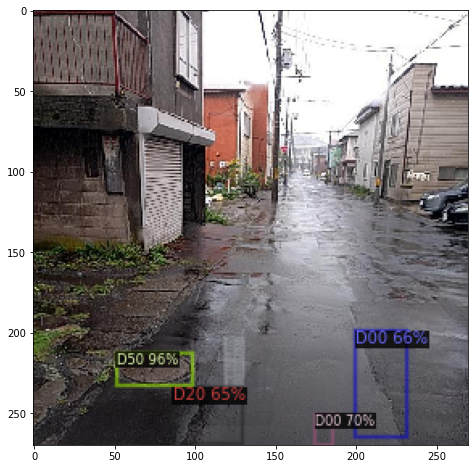

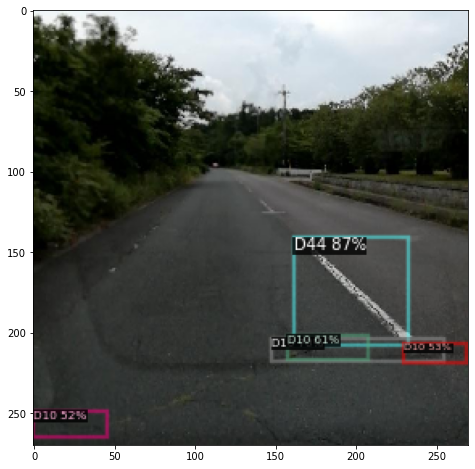

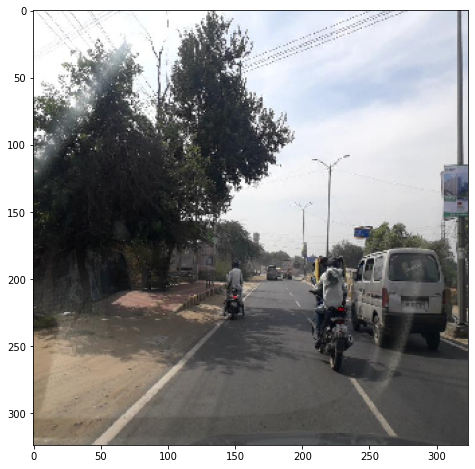

In [11]:
from detectron2.utils.visualizer import ColorMode
    
splits_per_dataset = ( "ltest/India", "ltest/Japan", "ltest/Czech")
dataset_dicts = dataCfg.load_images_ann_dicts(dataCfg.ROADDEFECT_DATASET, splits_per_dataset, dataCfg.RDD_DEFECT_CATEGORIES_ALL)

for idx, d in enumerate(random.sample(dataset_dicts, 3)):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    
    print(idx, ".) ", "-", d["file_name"], outputs["instances"].pred_classes)
    print("     ", outputs["instances"].scores)
    v = Visualizer(im[:, :, ::-1],
                   metadata=rdd2020_metadata, 
                   scale=0.45
    )

    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])